In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
def get_images(which):
    '''
    Returns a list of images specified by which parameter
    '''
    images = {
        'm': ['samples/m_1_1.jpg', 'samples/m_1_2.jpg', 'samples/m_1_3.jpg'],
        'mountain': ['samples/mountain_1.jpg', 'samples/mountain_2.jpg'],
        'rm': ['samples/rm1.jpg', 'samples/rm2.jpg', 'samples/rm3.jpg'],
        'bryce': ['samples/bryce_left_01.png', 'samples/bryce_right_01.png']
    }
    for im in images[which]:
        yield cv2.imread(im)

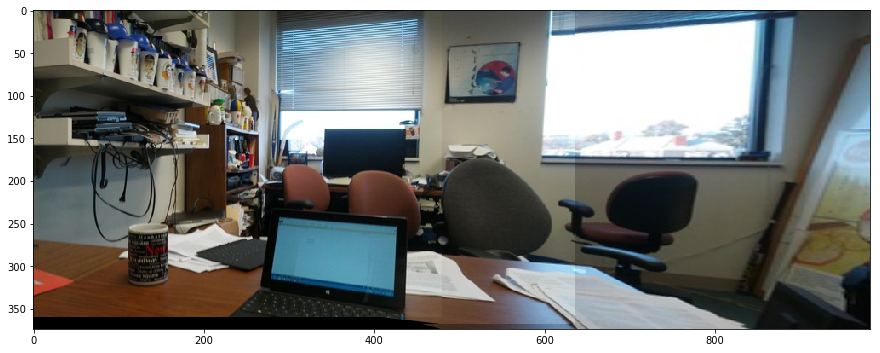

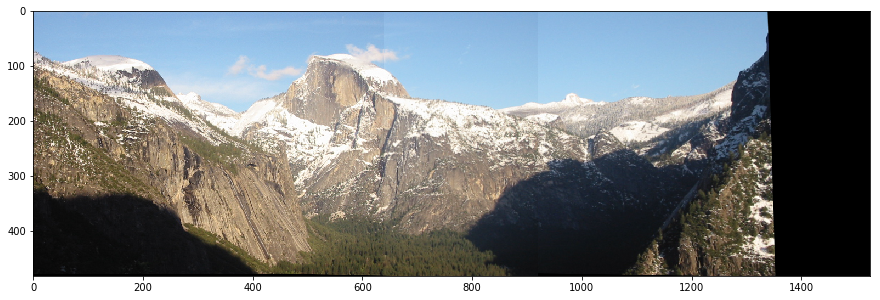

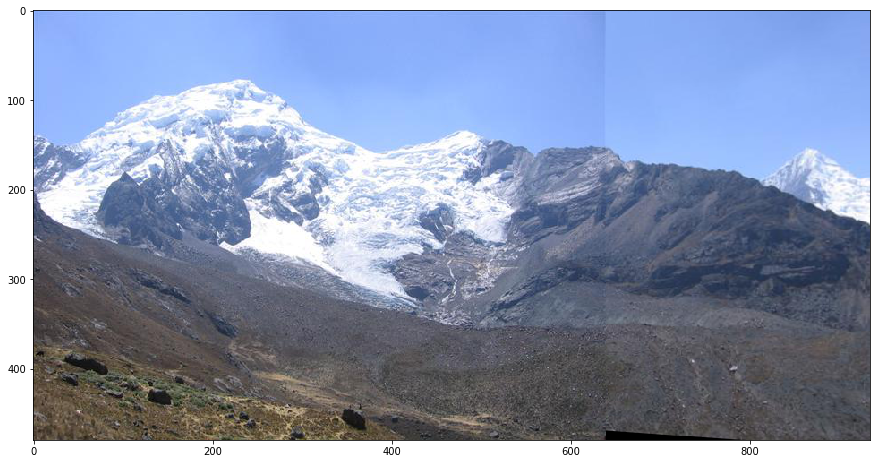

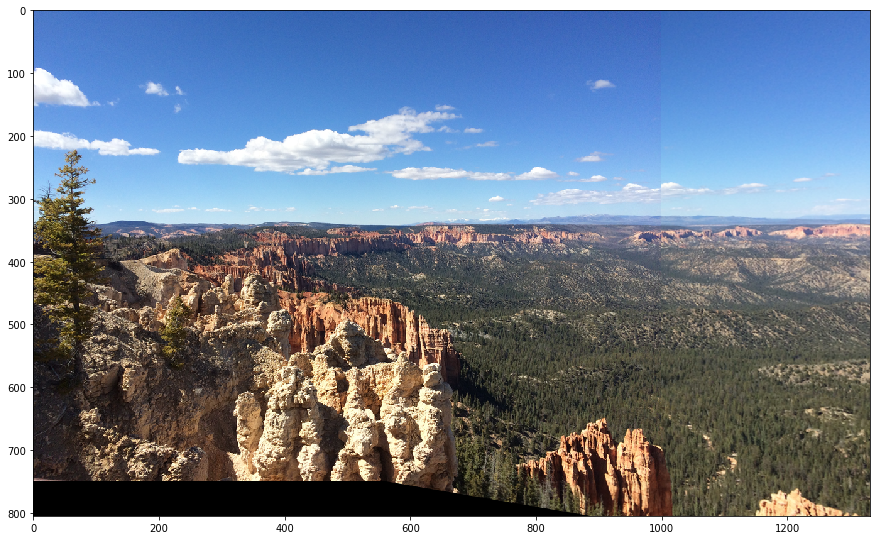

In [3]:
sift = cv2.xfeatures2d.SIFT_create()
bf = cv2.BFMatcher()

def display_stitch(which_images):
    last_image = None
    result = None
    #loop through our images
    for i, current_image in enumerate(get_images(which_images)):
        if i > 0:
            #detect keypoints
            kp1, des1 = sift.detectAndCompute(current_image, None)
            kp2, des2 = sift.detectAndCompute(last_image, None)
            #match keypoints and keep anything within 0.70
            matches = bf.knnMatch(des1, des2, k=2)
            good = []
            for m, n in matches:
                if m.distance < 0.70 * n.distance:
                    good.append(m)

            pts_src = np.array(list(kp1[m.queryIdx].pt for m in good))
            pts_dst = np.array(list(kp2[m.trainIdx].pt for m in good))
            #find the homography matrix
            M, mask = cv2.findHomography(pts_src, pts_dst, cv2.RANSAC, 5.0)
            #scale output by translation number
            x = int(M[0][2]) if int(M[0][2]) > 0 else 0
            y = int(M[1][2]) if int(M[1][2]) > 0 else 0
            #perspective warp
            result = cv2.warpPerspective(
                current_image,
                M,
                (
                    last_image.shape[1] + x,
                    last_image.shape[0] + y
                )
            )
            #apply previous image pixels to new image
            result[0:last_image.shape[0], 0:last_image.shape[1]] = last_image
            last_image = result

        else:
            last_image = current_image

    color_corrected = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(15,10))        
    plt.imshow(color_corrected)        
    
display_stitch("rm")    
display_stitch("m")
display_stitch("mountain")
display_stitch("bryce")